**Step 1: Install and Import Libraries**

In [1]:
# Install necessary libraries
!pip install tensorflow tqdm matplotlib

# Importing necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tqdm import tqdm


**Step 2: Explore the Dataset**

Good images: 4157
Bad images: 1023
Mask images: 1023


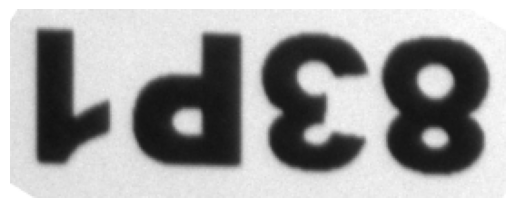

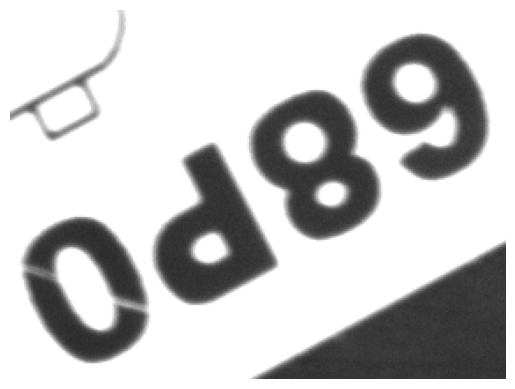

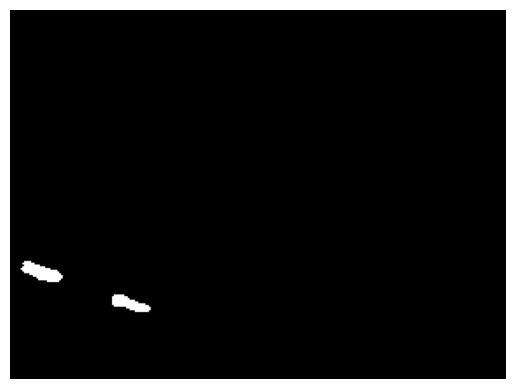

In [2]:
# Define the dataset path
good_folder = '/kaggle/input/detect/anomaly_detection_test_data/good'
bad_folder = '/kaggle/input/detect/anomaly_detection_test_data/bad'
mask_folder = '/kaggle/input/detect/anomaly_detection_test_data/masks'

# Check the number of images in each folder
good_images = os.listdir(good_folder)
bad_images = os.listdir(bad_folder)
mask_images = os.listdir(mask_folder)

print(f'Good images: {len(good_images)}')
print(f'Bad images: {len(bad_images)}')
print(f'Mask images: {len(mask_images)}')

# Display a few sample images from each folder
def display_image(image_path):
    img = load_img(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Display sample images from the Good, Bad, and Mask folders
display_image(os.path.join(good_folder, good_images[0]))
display_image(os.path.join(bad_folder, bad_images[0]))
display_image(os.path.join(mask_folder, mask_images[0]))


**Step 3: Image Resizing and Preprocessing**

**Step 4: Split the dataset**

In [3]:
# Step 1: Preprocessing the Images
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import numpy as np

# Define the dataset paths
good_folder = '/kaggle/input/detect/anomaly_detection_test_data/good'
bad_folder = '/kaggle/input/detect/anomaly_detection_test_data/bad'

# Function to preprocess an image
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)  # Resize image
    img_array = img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to preprocess all images in a folder
def preprocess_all_images(folder_path):
    images = os.listdir(folder_path)  # List all image filenames in the folder
    preprocessed_images = []  # List to store preprocessed images
    
    for img_name in images:
        img_path = os.path.join(folder_path, img_name)
        preprocessed_img = preprocess_image(img_path)
        preprocessed_images.append(preprocessed_img)
    
    return np.array(preprocessed_images)

# Preprocess all Good and Bad images
preprocessed_good_images = preprocess_all_images(good_folder)
preprocessed_bad_images = preprocess_all_images(bad_folder)

# Remove the extra dimension (from shape: (4157, 1, 224, 224, 3) to (4157, 224, 224, 3))
preprocessed_good_images = np.squeeze(preprocessed_good_images)
preprocessed_bad_images = np.squeeze(preprocessed_bad_images)

# Check the shapes of the preprocessed image arrays
print(f"Shape of preprocessed Good images: {preprocessed_good_images.shape}")
print(f"Shape of preprocessed Bad images: {preprocessed_bad_images.shape}")

# Step 2: Create Labels for Good and Bad images
good_labels = np.zeros(len(preprocessed_good_images))  # Label 0 for Good images
bad_labels = np.ones(len(preprocessed_bad_images))    # Label 1 for Bad images

# Check the labels
print(f"Good labels: {good_labels[:5]}")  # Show first 5 labels
print(f"Bad labels: {bad_labels[:5]}")    # Show first 5 labels

# Step 3: Split the Good and Bad images independently
from sklearn.model_selection import train_test_split

# Split the good and bad images into train, validation, and test sets
X_train_good, X_temp_good, y_train_good, y_temp_good = train_test_split(preprocessed_good_images, good_labels, test_size=0.2, random_state=42)
X_train_bad, X_temp_bad, y_train_bad, y_temp_bad = train_test_split(preprocessed_bad_images, bad_labels, test_size=0.2, random_state=42)

# Step 4: Combine the train, validation, and test sets for good and bad images
X_train = np.concatenate([X_train_good, X_train_bad], axis=0)
y_train = np.concatenate([y_train_good, y_train_bad], axis=0)

# For the validation and test sets, split them further as before
X_val_good, X_test_good, y_val_good, y_test_good = train_test_split(X_temp_good, y_temp_good, test_size=0.5, random_state=42)
X_val_bad, X_test_bad, y_val_bad, y_test_bad = train_test_split(X_temp_bad, y_temp_bad, test_size=0.5, random_state=42)

# Combine validation and test data
X_val = np.concatenate([X_val_good, X_val_bad], axis=0)
y_val = np.concatenate([y_val_good, y_val_bad], axis=0)

X_test = np.concatenate([X_test_good, X_test_bad], axis=0)
y_test = np.concatenate([y_test_good, y_test_bad], axis=0)

# Check the sizes of each set
print(f"Training images: {X_train.shape[0]}")
print(f"Validation images: {X_val.shape[0]}")
print(f"Test images: {X_test.shape[0]}")


Shape of preprocessed Good images: (4157, 224, 224, 3)
Shape of preprocessed Bad images: (1023, 224, 224, 3)
Good labels: [0. 0. 0. 0. 0.]
Bad labels: [1. 1. 1. 1. 1.]
Training images: 4143
Validation images: 518
Test images: 519


**Step 5: Build the Model**

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

# Step 1: Load the Pre-trained ResNet50 Model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(1, activation='sigmoid')(x)  # Binary classification layer

# Final Model
model = Model(inputs=base_model.input, outputs=x)

# Step 3: Freeze the base model layers (optional to speed up training)
for layer in base_model.layers:
    layer.trainable = False

# Step 4: Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',  # Since it's a binary classification
              metrics=['accuracy'])

# Step 5: Add early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Step 6: Train the model with TQDMCallback for progress tracking
history = model.fit(
    X_train, y_train,  # Training data
    epochs=150,  # Number of epochs (you can increase this)
    batch_size=16,
    validation_data=(X_val, y_val),  # Validation data
    callbacks=[early_stopping, TqdmCallback(verbose=1)]  # Add TQDMCallback
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/150


I0000 00:00:1733551176.331959     110 service.cc:145] XLA service 0x7c6e90003610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733551176.332035     110 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733551176.332041     110 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  3/259 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.7222 - loss: 0.4191 

I0000 00:00:1733551181.176348     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


259/259 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.8237 - loss: 0.3970 - val_accuracy: 0.8649 - val_loss: 0.3187
Epoch 2/150
259/259 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.8566 - loss: 0.3318 - val_accuracy: 0.8977 - val_loss: 0.2936
Epoch 3/150
259/259 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.8792 - loss: 0.2963 - val_accuracy: 0.9093 - val_loss: 0.2753
Epoch 4/150
259/259 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.8948 - loss: 0.2719 - val_accuracy: 0.9131 - val_loss: 0.2610
Epoch 5/150
259/259 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.8992 - loss: 0.2634 - val_accuracy: 0.9189 - val_loss: 0.2481
Epoch 6/150
259/259 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.9032 - loss: 0.2564 - val_accuracy: 0.9151 - val_loss: 0.2391
Epoch 7/150
259/259 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.9130 - loss: 0.2375 - val_accuracy: 0.9228 - val_loss: 0.2303
Epoch 8/150
259/259 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.9176 - loss: 0.2227 - val_

**Test**

17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 316ms/step
Confusion Matrix:
[[413   3]
 [ 23  80]]


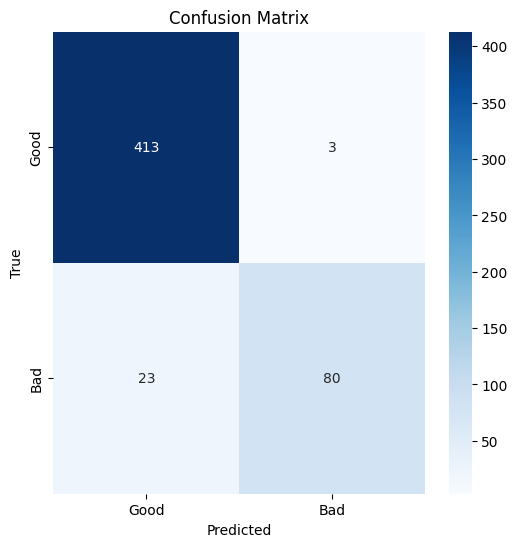

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       416
         1.0       0.96      0.78      0.86       103

    accuracy                           0.95       519
   macro avg       0.96      0.88      0.91       519
weighted avg       0.95      0.95      0.95       519



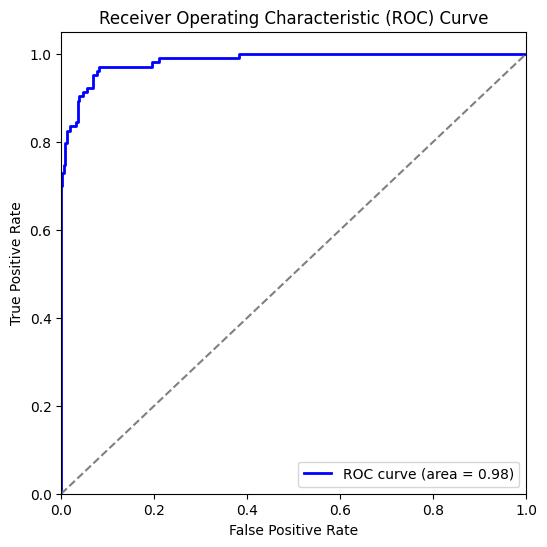

In [5]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# Step 1: Make predictions on the test set
y_pred_prob = model.predict(X_test)  # Predict probability of class
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary class predictions (0 or 1)

# Step 2: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Good", "Bad"], yticklabels=["Good", "Bad"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Step 3: Classification Report (Precision, Recall, F1-Score)
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Step 4: ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


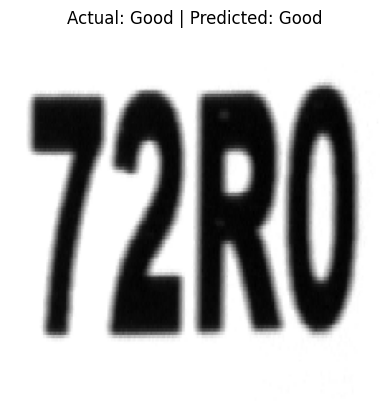

Predicted Probability (Bad): 0.0050


In [33]:
#Randomly pick an image and predict for good and bad image

import numpy as np
import matplotlib.pyplot as plt

# Select a random index from the test set
test_index = np.random.randint(0, len(X_test))

# Extract the test image and its actual label
test_image = X_test[test_index]
actual_label = "Bad" if y_test[test_index] == 1 else "Good"

# Add a batch dimension (required for model prediction)
test_image_batch = np.expand_dims(test_image, axis=0)

# Make the prediction
predicted_prob = model.predict(test_image_batch)
predicted_label = "Bad" if predicted_prob[0][0] > 0.5 else "Good"

# Reverse preprocessing for display
test_image_display = (test_image - test_image.min()) / (test_image.max() - test_image.min())  # Normalize between 0 and 1

# Display the image with prediction and actual label
plt.imshow(test_image_display)
plt.title(f"Actual: {actual_label} | Predicted: {predicted_label}")
plt.axis('off')
plt.show()

# Print the predicted probability
print(f"Predicted Probability (Bad): {predicted_prob[0][0]:.4f}")
